In [1]:
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel,Field
from dotenv import load_dotenv
from typing import TypedDict,List
import operator
from langchain_google_genai import ChatGoogleGenerativeAI
import httpx
from langchain_openai import ChatOpenAI,AzureChatOpenAI


In [13]:
import os
load_dotenv()
api_key=os.getenv('GEMINI_API_KEY')

In [ ]:
model=ChatGoogleGenerativeAI(
    api_key=api_key,
    model='gemini-2.5-flash'
)


In [15]:
class GitHubRepoState(TypedDict):
    username: str
    repos: list[dict]
    languages: list[str]


In [17]:
class GithubClient:
    def __init__(self,token):
        self.token = token
        self.base_url="https://api.github.com/"

    def _headers(self):
        return{
            "Authorization": f"Bearer {self.token}",
            "Accept": "application/vnd.github.v3+json",
        }
    
    def get_proj_repos(self,username):
        response=httpx.get(f"{self.base_url}users/{username}/repos", headers=self._headers())
        response.raise_for_status()
        return response.json()
    
    def get_proj_languages(self,owner,repo):
        response=httpx.get(f"{self.base_url}repos/{owner}/{repo}/languages", headers=self._headers())
        response.raise_for_status()
        return response.json()
    
    def get_proj_readme(self,owner,repo):
        readme=httpx.get(f'https://raw.githubusercontent.com/{owner}/{repo["name"]}/main/README.md')
        if readme.status_code == 404:
            return None  # README not found
        readme.raise_for_status()  # raise for other unexpected errors

        return readme.text

In [18]:
def get_github_repos_details(state: GitHubRepoState):
    client=GithubClient(token=os.getenv('GITHUB_TOKEN'))
    repos=client.get_proj_repos(state["username"])
    languages=set()
    required_repo_data=[]
    for repo in repos:
        readme=client.get_proj_readme(state["username"],repo)
        
        required_data={
            "repository_name": repo["name"],
            "repository_url":repo['html_url'],
            "repository_language_url":repo['languages_url'],
            "repository_readme": readme
        }
        languages_data=httpx.get(required_data['repository_language_url'], headers=client._headers())
        languages_data.raise_for_status()
        languages.update(languages_data.json().keys())
        required_repo_data.append(required_data)

    return {"repos": required_repo_data,"languages":list(languages)}

In [19]:
class ReadmeStructured(BaseModel):
    frontend_frameworks: List[str] = Field(description="List the frontend frameworks,libraries and technology  mentioned in the README")
    backend_frameworks: List[str] = Field(description="List the backend frameworks,libraries and technology  mentioned in the README")
    database: List[str] = Field(description="List the databases mentioned in the README")
    tools: List[str] = Field(description="List the tools mentioned in the README")

readme_parser_model=model.with_structured_output(ReadmeStructured)

In [20]:
def refine_readme(state: GitHubRepoState):
    for repo in state["repos"]:
        readme_content = repo.get("repository_readme", "")
        prompt = f'''
                You are given the README content of a GitHub repository.

                Your task:
                1. Carefully read the README text.
                2. Extract information into the following JSON structure:

                {{
                "frontend_frameworks": [list of frontend frameworks,libraries and technology explicitly mentioned in the README],
                "backend_frameworks": [list of backend frameworks,libraries and technologyexplicitly mentioned in the README],
                "database": [list of databases explicitly mentioned in the README],
                "tools": [list of tools explicitly mentioned in the README]
                }}
    
                Rules:
                - Only include a technology if it is **explicitly** mentioned in the README.
                - If a category has no explicit mentions, set its value to `null` (NOT an empty string, NOT a guess).
                - Do not infer or assume any technology from context — if it’s not explicitly stated, return `null` for that category.
                - Output must be **valid JSON** that strictly follows the given structure and field names.

                README content:
                {readme_content}
        '''
        refined_readme = readme_parser_model.invoke(prompt)
        repo["repository_readme_structured"] = refined_readme.model_dump()
    return state

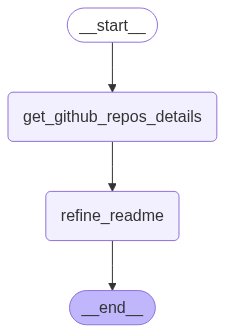

In [21]:
graph=StateGraph(GitHubRepoState,
                 merge={
                     "repos": operator.add,
                     "languages": operator.add
                 })
graph.add_node('get_github_repos_details',get_github_repos_details)
graph.add_node('refine_readme',refine_readme)
graph.add_edge(START,'get_github_repos_details')
graph.add_edge('get_github_repos_details','refine_readme')
graph.add_edge('refine_readme',END)
workflow=graph.compile()

workflow

In [22]:
initial_state={"username":"Ashish0243"}
final_state=workflow.invoke(initial_state)
print(final_state)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 54
}
].


{'username': 'Ashish0243', 'repos': [{'repository_name': '1strep', 'repository_url': 'https://github.com/Ashish0243/1strep', 'repository_language_url': 'https://api.github.com/repos/Ashish0243/1strep/languages', 'repository_readme': None, 'repository_readme_structured': {'frontend_frameworks': [], 'backend_frameworks': [], 'database': [], 'tools': []}}, {'repository_name': 'Backend', 'repository_url': 'https://github.com/Ashish0243/Backend', 'repository_language_url': 'https://api.github.com/repos/Ashish0243/Backend/languages', 'repository_readme': None, 'repository_readme_structured': {'frontend_frameworks': [], 'backend_frameworks': [], 'database': [], 'tools': []}}, {'repository_name': 'Blog', 'repository_url': 'https://github.com/Ashish0243/Blog', 'repository_language_url': 'https://api.github.com/repos/Ashish0243/Blog/languages', 'repository_readme': None, 'repository_readme_structured': {'frontend_frameworks': [], 'backend_frameworks': [], 'database': [], 'tools': []}}, {'reposit